In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re

In [5]:
# Get a list of all the urls for the avalanche reports for Salt-Lake
# page_numbers = range(17) #0 - 16 inclusive
# url_base = 'https://utahavalanchecenter.org/archives/forecasts/salt-lake?page='
# urls = [url_base + str(page_number) for page_number in page_numbers]

# sub_urls = []


# REQUESTS
# for website in urls:
#     response = requests.get(website)
#     soup = BeautifulSoup(response.content, 'html.parser')
#     links = soup.find_all('a')
#     for link in links:
#         print(link.get('href'))
#         sub_urls.append(link.get('href'))

# pd.DataFrame(sub_urls).to_csv('sub_urls.csv')


In [6]:
# Clean the data and put it into a dataframe
# df = pd.read_csv('resources/sub_urls.csv')
# df.columns = ['index', 'url']

# # filter urls with prefix 'https://utahavalanchecenter.org/forecast/salt-lake/'
# df = df[df['url'].str.startswith('https://utahavalanchecenter.org/forecast/salt-lake/')]
# df = df.reset_index(drop=True)
# df['url'] = df['url'].str.replace('https://utahavalanchecenter.org/forecast/salt-lake/', '')


In [7]:
# More cleaning
# prefix = '/forecast/salt-lake/'
# df = df.fillna('') # fill NaNs with empty string
# df = df[df['url'].str.startswith(prefix)]
# df = df.reset_index(drop=True)
# base = 'https://utahavalanchecenter.org'
# df['url'] = base + df['url']

In [8]:
# Drop duplicates and save to csv
# df.drop_duplicates(subset=['url'], inplace=True)
# df = df.reset_index(drop=True)
# df.to_csv('daily_reports_urls.csv', index=False)

In [9]:
df = pd.read_csv('resources/daily_reports_urls.csv')

In [10]:
def get_page_source(url):
    response = requests.get(url)
    page_source = response.content
    return page_source

In [11]:
page_source = get_page_source('https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023')

In [12]:
# first link will be the overall forecast image
def get_rose_image_links(page_source):
    # find all links that start with '/sites/default/files/forecast/'
    links = re.findall(r'<img.*?src="/(sites/default/files/forecast/.*?)">', page_source.decode('utf-8'))
    # append 'https://utahavalanchecenter.org' to the beginning of each link
    links = ['https://utahavalanchecenter.org/' + link for link in links]
    return links

links = get_rose_image_links(page_source)


In [13]:
def get_color(image, pixel_location):
    return image.getpixel(pixel_location)

In [14]:
def load_image(url):
    return Image.open(requests.get(url, stream=True).raw)

In [15]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [16]:
def classify_color(rgba):
    color_map = {
        'red': (237, 28, 36, 255), # High
        'orange': (247, 148, 30, 255), # Considerable
        'yellow': (255, 242, 0, 255), # Moderate
        'green': (80, 184, 72, 255), # Low
        'blue': (68, 187, 238, 255), #
        'gray': (192, 192, 192, 255), # 
        'white': (255, 255, 255, 255), #'  
        'black': (0, 0, 0, 255), # Extreme
        'transparent': (0, 0, 0, 0) #
    }
    # Get the color with the smallest distance from the given color
    from scipy.spatial import distance
    distances = []
    for color in color_map.values():
        if len(rgba) == 3:
            rgba = rgba + (255,)
        distances.append(distance.euclidean(rgba, color))
    min_index = np.argmin(distances)
    return list(color_map.keys())[min_index]

In [17]:
def get_forecast_level(image, pixel_locations):
    # Get the color at each pixel for a list of pixel locations
    colors = []
    for location in pixel_locations:
        rgba = get_color(image, location)
        color = classify_color(rgba)
        colors.append(color)
    return colors

In [18]:
def get_forecast_from_image(image):
    pixel_map = {
        'high': {
            'N': (200, 132),
            'NE': (220, 132),
            'E': (240, 154),
            'SE': (220, 176),
            'S': (200, 176),
            'SW': (180, 176),
            'W': (160, 154),
            'NW': (180, 132)
        },
        'mid': {
            'N': (200, 110),
            'NE': (240, 110),
            'E': (270, 154),
            'SE': (240, 220),
            'S': (200, 230),
            'SW': (140, 198),
            'W': (120, 154),
            'NW': (140, 110),
        },
        'low': {
            'N': (200, 66),
            'NE': (300, 110),
            'E': (320, 176),
            'SE': (280, 264),
            'S': (200, 286),
            'SW': (100, 242),
            'W': (80, 176),
            'NW': (100, 110),
        },    
    }
    forecast = {}
    for level, pixel_locations in pixel_map.items():
        forecast[level] = get_forecast_level(image, pixel_locations.values())
    return forecast

In [19]:
def get_forecast_from_url(image_url):
    image = load_image(image_url)
    forecast = get_forecast_from_image(image)
    return forecast


In [20]:
def get_danger_level(level_forecast):
    danger_map = {
        'black': 4,
        'red': 3,
        'orange': 2,
        'yellow': 1,
        'green': 0,
    }
    dangers = [danger_map[danger] for danger in level_forecast]
    for key, value in danger_map.items():
        if value == max(dangers):
            return key
    return None

In [21]:
links

['https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230222-064416-6.png',
 'https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230222-064416-1.png',
 'https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230222-064416-3.png']

In [22]:
image = load_image(links[0])

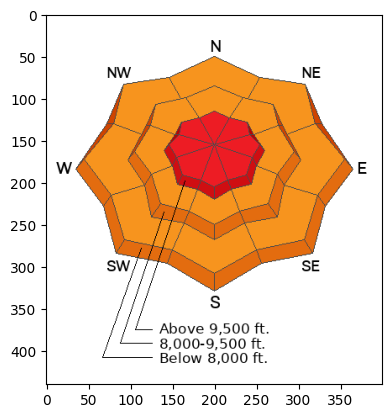

In [23]:
show_image(image)

In [24]:
def get_avalanche_problem_from_image(image):
    avalanche_danger_map = {
        'high': {
            'N': (230, 140),
            'NE': (250, 140),
            'E': (264, 160),
            'SE': (250, 180),
            'S': (230, 200),
            'SW': (210, 180),
            'W': (200, 160),
            'NW': (210, 140)
        },
        'mid': {
            'N': (230, 120),
            'NE': (286, 120),
            'E': (307, 160),
            'SE': (286, 220),
            'S': (230, 240),
            'SW': (176, 220),
            'W': (154, 170),
            'NW': (176, 120),
        },
        'low': {
            'N': (230, 80),
            'NE': (308, 100),
            'E': (352, 180),
            'SE': (330, 260),
            'S': (230, 300),
            'SW': (132, 260),
            'W': (110, 180),
            'NW': (132, 100),
        },   
    }
    forecast = {}
    for level, pixel_locations in avalanche_danger_map.items():
        forecast[level] = get_forecast_level(image, pixel_locations.values())
    return forecast

In [25]:
def extract_avalanche_problems(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    divs = soup.find_all('div', string=lambda t: t and 'Avalanche Problem #' in t)
    problems = []
    for div in divs:
        h5 = div.find_next_sibling('h5')
        if h5:
            problems.append(h5.text)
    return problems

def extract_locations(page_source):
    links = get_rose_image_links(page_source)
    location_links = links[1:]
    locations = []
    for link in location_links:
        locations.append(get_avalanche_problem_from_image(load_image(link)))
    return locations


def extract_likelihood_numbers(page_source):
    # Find all image links that contain 'likelihood' in the URL
    links = re.findall(r'<img.*?src="(.*?likelihood.*?)".*?>', page_source.decode('utf-8'))
    # Extract the number from each URL using regular expressions
    numbers = [re.search(r'likelihood_(\d+)\.jpg', link).group(1) for link in links]
    return numbers

def extract_size_numbers(page_source):
    # Find all image links that contain 'size' in the URL
    # url: /sites/all/themes/custom/basscss/images/icons/size/size_01.jpg
    
    links = re.findall(r'<img.*?src="(.*?size.*?)".*?>', page_source.decode('utf-8'))
    # for link in links:
    #     print(link)
    # Extract the number from each URL using regular expressions
    numbers = []
    for link in links:
        try:
            numbers.append(re.search(r'size_(\d+)\.jpg', link).group(1))
        except:
            print("Skipping Bad URL: " + link)
            pass
    return numbers

def get_avalanche_problems(page_source):
    # try:
    problem_types = extract_avalanche_problems(page_source)
    likelihood_numbers = extract_likelihood_numbers(page_source)
    size_numbers = extract_size_numbers(page_source)
    locations = extract_locations(page_source)
    problems = []
    for i in range(len(problem_types)):
        problem = {
            'type': problem_types[i],
            'likelihood': likelihood_numbers[i],
            'size': size_numbers[i],
            'location': locations[i]
        }
        problems.append(problem)
    
    return problems
    # except Exception as e:
    #     print(e)
    #     return []

In [26]:
get_avalanche_problems(page_source)[0]

{'type': 'Wind Drifted Snow',
 'likelihood': '04',
 'size': '02',
 'location': {'high': ['blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue'],
  'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
  'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}}

In [27]:
def get_avalanche(url):
    page_source = get_page_source(url)
    links = get_rose_image_links(page_source)
    forecast = get_forecast_from_url(links[0])
    level_forecasts = [forecast['high'], forecast['mid'], forecast['low']]
    # get avalanche problems roses
    problems = get_avalanche_problems(page_source)
    return {
        'forecast': forecast,
        'level_forecasts': level_forecasts, #redundant
        'problems': problems,
    }

In [28]:
get_avalanche('https://utahavalanchecenter.org/forecast/salt-lake/3/2/2023')

{'forecast': {'high': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'mid': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'low': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']},
 'level_forecasts': [['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']],
 'problems': [{'type': 'Wind Drifted Snow',
   'likelihood': '02',
   'size': '04',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'],
    'low': ['gray', 'gray', '

In [29]:
avalanche = pd.DataFrame(columns=['date', 
                                  'HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW', #overall risk
                                  'MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',
                                  'LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',
                                  'high', 'mid', 'low',
                                  'problem_1_type', 'likelihood_1', 'size_1',          #problem 1
                                  'HN1', 'HNE1', 'HE1', 'HSE1', 'HS1', 'HSW1', 'HW1', 'HNW1',
                                  'MN1', 'MNE1', 'ME1', 'MSE1', 'MS1', 'MSW1', 'MW1', 'MNW1',
                                  'LN1', 'LNE1', 'LE1', 'LSE1', 'LS1', 'LSW1', 'LW1', 'LNW1',
                                  'high1', 'mid1', 'low1',
                                  'problem_2_type', 'likelihood_2', 'size_2',          #problem 2
                                  'HN2', 'HNE2', 'HE2', 'HSE2', 'HS2', 'HSW2', 'HW2', 'HNW2',
                                  'MN2', 'MNE2', 'ME2', 'MSE2', 'MS2', 'MSW2', 'MW2', 'MNW2',
                                  'LN2', 'LNE2', 'LE2', 'LSE2', 'LS2', 'LSW2', 'LW2', 'LNW2',
                                  'high2', 'mid2', 'low2',
                                  'problem_3_type', 'likelihood_3', 'size_3',           #problem 3
                                  'HN3', 'HNE3', 'HE3', 'HSE3', 'HS3', 'HSW3', 'HW3', 'HNW3',
                                  'MN3', 'MNE3', 'ME3', 'MSE3', 'MS3', 'MSW3', 'MW3', 'MNW3',
                                  'LN3', 'LNE3', 'LE3', 'LSE3', 'LS3', 'LSW3', 'LW3', 'LNW3',
                                  'high3', 'mid3', 'low3',      
                            ])

In [30]:
ex = {'forecast': {'high': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'mid': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'low': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']},
 'level_forecasts': [['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']],
 'problems': [{'type': 'Wind Drifted Snow',
   'likelihood': '02',
   'size': '04',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'],
    'low': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']}},
  {'type': 'New Snow',
   'likelihood': '02',
   'size': '03',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
    'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}},
  {'type': 'Wet Snow',
   'likelihood': '02',
   'size': '02',
   'location': {'high': ['gray',
     'gray',
     'gray',
     'blue',
     'blue',
     'blue',
     'gray',
     'gray'],
    'mid': ['gray', 'gray', 'gray', 'blue', 'blue', 'blue', 'gray', 'gray'],
    'low': ['gray', 'gray', 'gray', 'blue', 'blue', 'blue', 'gray', 'gray']}}]}


In [31]:
color_risk_map = {
    'black': 5,
    'red': 4,
    'orange': 3,
    'yellow': 2,
    'green': 1,
    'gray': 0,
}

def lists_to_dict(lists):
    keys = {'high': ['HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW',],
            'mid': ['MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',],
            'low': ['LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',],
    }
    levels = ['high', 'mid', 'low']
    dict = {}
    level_avg = {}
    for i, level in enumerate(levels):
        key = keys[level]
        list = lists[level]
        total = 0
        for j, color in enumerate(list):
            dict[key[j]] = color
            total += color_risk_map[color]
        level_avg[level] = total / len(list)
    return dict, level_avg


In [32]:
f = get_avalanche('https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023')

In [33]:
def get_date(url):
    date = re.search(r'/(\d+)/(\d+)/(\d+)$', url).groups()
    date = '/'.join(date)
    return date

In [34]:
get_date('https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023')

'2/22/2023'

In [35]:
f['problems']

[{'type': 'Wind Drifted Snow',
  'likelihood': '04',
  'size': '02',
  'location': {'high': ['blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue'],
   'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
   'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}},
 {'type': 'New Snow',
  'likelihood': '03',
  'size': '02',
  'location': {'high': ['blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'blue'],
   'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
   'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}}]

In [36]:
# 'problem_1_type', 'likelihood_1', 'size_1',          #problem 1
#                                   'HN1', 'HNE1', 'HE1', 'HSE1', 'HS1', 'HSW1', 'HW1', 'HNW1',
#                                   'MN1', 'MNE1', 'ME1', 'MSE1', 'MS1', 'MSW1', 'MW1', 'MNW1',
#                                   'LN1', 'LNE1', 'LE1', 'LSE1', 'LS1', 'LSW1', 'LW1', 'LNW1',
#                                   'high1', 'mid1', 'low1',
def problem_dict_to_expanded_dict(problem, problem_number):
    dict = {}
    dict['problem_' + str(problem_number) + '_type'] = problem['type']
    dict['likelihood_' + str(problem_number)] = problem['likelihood']
    dict['size_' + str(problem_number)] = problem['size']
    
    for level, level_abr in zip(['high', 'mid', 'low'], ['H', 'M', 'L']):
        count = 0
        for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
            dict[level_abr + direction + str(problem_number)] = problem['location'][level][i]
            if problem['location'][level][i] == 'blue':
                count += 1
        dict[level + str(problem_number)] = count / 8
    return dict

In [37]:
problem_dict_to_expanded_dict(f['problems'][0], 1)

{'problem_1_type': 'Wind Drifted Snow',
 'likelihood_1': '04',
 'size_1': '02',
 'HN1': 'blue',
 'HNE1': 'blue',
 'HE1': 'blue',
 'HSE1': 'blue',
 'HS1': 'blue',
 'HSW1': 'blue',
 'HW1': 'blue',
 'HNW1': 'blue',
 'high1': 1.0,
 'MN1': 'blue',
 'MNE1': 'blue',
 'ME1': 'blue',
 'MSE1': 'blue',
 'MS1': 'blue',
 'MSW1': 'blue',
 'MW1': 'blue',
 'MNW1': 'blue',
 'mid1': 1.0,
 'LN1': 'blue',
 'LNE1': 'blue',
 'LE1': 'blue',
 'LSE1': 'blue',
 'LS1': 'blue',
 'LSW1': 'blue',
 'LW1': 'blue',
 'LNW1': 'blue',
 'low1': 1.0}

In [38]:
dict1 = {'a': 1, 'b': 2}
dict2 = {'c': 3, 'd': 4}

dict1.update(dict2)
print(dict1)


{'a': 1, 'b': 2, 'c': 3, 'd': 4}


In [39]:
def get_row(url):
    date = get_date(url)
    forecast = get_avalanche(url)
    
    direction_colors, level_avgs = lists_to_dict(forecast['forecast'])
    avalanche_problems = forecast['problems']
    avalanche_problem_dict = {}
    for i, problem in enumerate(avalanche_problems):
        avalanche_problem_dict.update(problem_dict_to_expanded_dict(problem, i+1))
    
    
    
    new_row = {'date': date,
               'url': url,
                **direction_colors,
                **level_avgs,
                **avalanche_problem_dict
    }
    return new_row


In [40]:
get_row('https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023')

{'date': '2/22/2023',
 'url': 'https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023',
 'HN': 'red',
 'HNE': 'red',
 'HE': 'red',
 'HSE': 'red',
 'HS': 'red',
 'HSW': 'red',
 'HW': 'red',
 'HNW': 'red',
 'MN': 'orange',
 'MNE': 'orange',
 'ME': 'orange',
 'MSE': 'orange',
 'MS': 'orange',
 'MSW': 'orange',
 'MW': 'orange',
 'MNW': 'orange',
 'LN': 'orange',
 'LNE': 'orange',
 'LE': 'orange',
 'LSE': 'orange',
 'LS': 'orange',
 'LSW': 'orange',
 'LW': 'orange',
 'LNW': 'orange',
 'high': 4.0,
 'mid': 3.0,
 'low': 3.0,
 'problem_1_type': 'Wind Drifted Snow',
 'likelihood_1': '04',
 'size_1': '02',
 'HN1': 'blue',
 'HNE1': 'blue',
 'HE1': 'blue',
 'HSE1': 'blue',
 'HS1': 'blue',
 'HSW1': 'blue',
 'HW1': 'blue',
 'HNW1': 'blue',
 'high1': 1.0,
 'MN1': 'blue',
 'MNE1': 'blue',
 'ME1': 'blue',
 'MSE1': 'blue',
 'MS1': 'blue',
 'MSW1': 'blue',
 'MW1': 'blue',
 'MNW1': 'blue',
 'mid1': 1.0,
 'LN1': 'blue',
 'LNE1': 'blue',
 'LE1': 'blue',
 'LSE1': 'blue',
 'LS1': 'blue',
 'LSW1': 'blue'

In [42]:
def generate_empty_df():
    return pd.DataFrame(columns=['date', 
                                  'url',
                                  'HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW', #overall risk
                                  'MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',
                                  'LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',
                                  'high', 'mid', 'low',
                                  'problem_1_type', 'likelihood_1', 'size_1',          #problem 1
                                  'HN1', 'HNE1', 'HE1', 'HSE1', 'HS1', 'HSW1', 'HW1', 'HNW1',
                                  'MN1', 'MNE1', 'ME1', 'MSE1', 'MS1', 'MSW1', 'MW1', 'MNW1',
                                  'LN1', 'LNE1', 'LE1', 'LSE1', 'LS1', 'LSW1', 'LW1', 'LNW1',
                                  'high1', 'mid1', 'low1',
                                  'problem_2_type', 'likelihood_2', 'size_2',          #problem 2
                                  'HN2', 'HNE2', 'HE2', 'HSE2', 'HS2', 'HSW2', 'HW2', 'HNW2',
                                  'MN2', 'MNE2', 'ME2', 'MSE2', 'MS2', 'MSW2', 'MW2', 'MNW2',
                                  'LN2', 'LNE2', 'LE2', 'LSE2', 'LS2', 'LSW2', 'LW2', 'LNW2',
                                  'high2', 'mid2', 'low2',
                                  'problem_3_type', 'likelihood_3', 'size_3',           #problem 3
                                  'HN3', 'HNE3', 'HE3', 'HSE3', 'HS3', 'HSW3', 'HW3', 'HNW3',
                                  'MN3', 'MNE3', 'ME3', 'MSE3', 'MS3', 'MSW3', 'MW3', 'MNW3',
                                  'LN3', 'LNE3', 'LE3', 'LSE3', 'LS3', 'LSW3', 'LW3', 'LNW3',
                                  'high3', 'mid3', 'low3',      
                            ])

In [43]:
new = get_row('https://utahavalanchecenter.org/forecast/salt-lake/2/22/2023')

In [44]:
avalanche = pd.concat([avalanche, pd.DataFrame([new])], ignore_index=True)

C:\Users\justi\AppData\Local\Temp\ipykernel_20700\1538609120.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avalanche = pd.concat([avalanche, pd.DataFrame([new])], ignore_index=True)


In [45]:
generate_empty_df().head()

,date,url,HN,HNE,HE,HSE,HS,HSW,HW,HNW,...,LNE3,LE3,LSE3,LS3,LSW3,LW3,LNW3,high3,mid3,low3


In [46]:
urls = pd.read_csv('resources/daily_reports_urls.csv')

In [47]:
print(urls.shape)
urls.head()

(824, 2)


,index,url
0,106,https://utahavalanchecenter.org/forecast/salt-...
1,107,https://utahavalanchecenter.org/forecast/salt-...
2,108,https://utahavalanchecenter.org/forecast/salt-...
3,109,https://utahavalanchecenter.org/forecast/salt-...
4,110,https://utahavalanchecenter.org/forecast/salt-...


In [48]:
from time import sleep

In [49]:
urls = pd.read_csv('resources/daily_reports_urls.csv')

In [50]:
print(urls['url'].iloc[426])

https://utahavalanchecenter.org/forecast/salt-lake/1/23/2021


In [51]:
avalanche = pd.read_csv('resources/avalanche_report.csv')

In [52]:
# Generate the Avalanche Reports for Salt Lake back to 10/2018
# df = generate_empty_df()
# avalanche = pd.read_csv('resources/avalanche_report.csv')
# for i, url in enumerate(urls['url'].iloc[426:]):
#     print(i, ": ", url)
#     try:
#         new = get_row(url)
#         avalanche = pd.concat([avalanche, pd.DataFrame([new])], ignore_index=True)
#     except:
#         print('Error with url: ', url, ' at index: ', i)
#     if i % 10 == 0:
#         avalanche.to_csv('resources/avalanche_report.csv', index=False)
#     sleep(1)


In [53]:
get_row('https://utahavalanchecenter.org/forecast/salt-lake/1/23/2021')

{'date': '1/23/2021',
 'url': 'https://utahavalanchecenter.org/forecast/salt-lake/1/23/2021',
 'HN': 'red',
 'HNE': 'red',
 'HE': 'red',
 'HSE': 'red',
 'HS': 'red',
 'HSW': 'red',
 'HW': 'red',
 'HNW': 'red',
 'MN': 'red',
 'MNE': 'red',
 'ME': 'red',
 'MSE': 'orange',
 'MS': 'orange',
 'MSW': 'orange',
 'MW': 'red',
 'MNW': 'red',
 'LN': 'orange',
 'LNE': 'orange',
 'LE': 'orange',
 'LSE': 'orange',
 'LS': 'orange',
 'LSW': 'orange',
 'LW': 'orange',
 'LNW': 'orange',
 'high': 4.0,
 'mid': 3.625,
 'low': 3.0,
 'problem_1_type': 'Persistent Weak Layer',
 'likelihood_1': '04',
 'size_1': '03',
 'HN1': 'blue',
 'HNE1': 'blue',
 'HE1': 'blue',
 'HSE1': 'blue',
 'HS1': 'gray',
 'HSW1': 'gray',
 'HW1': 'blue',
 'HNW1': 'blue',
 'high1': 0.75,
 'MN1': 'blue',
 'MNE1': 'blue',
 'ME1': 'blue',
 'MSE1': 'blue',
 'MS1': 'gray',
 'MSW1': 'gray',
 'MW1': 'blue',
 'MNW1': 'blue',
 'mid1': 0.75,
 'LN1': 'blue',
 'LNE1': 'blue',
 'LE1': 'blue',
 'LSE1': 'gray',
 'LS1': 'gray',
 'LSW1': 'gray',
 'LW1

# Attempt at getting 2018-2013 data

In [54]:
'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131223.html'

'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131223.html'

In [74]:
directory_url = 'https://utahavalanchecenter.org/archive/advisories/salt-lake'
response = requests.get(directory_url)
soup = BeautifulSoup(response.content, 'html.parser')
links = soup.find_all('a')
# links should look like  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html

filtered_links = []
for link in links:
    if link.get('href') and link.get('href').startswith('/sites/default/files/archive/advisory/print/advisory/salt-lake/'):
        filtered_links.append(link.get('href'))
# print(filtered_links)
sorted_links = sorted(filtered_links)
# print(sorted_links)
for i, link in enumerate(sorted_links):
    if link == '/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html':
        print(i)
links = sorted_links[1894:]
base = 'https://utahavalanchecenter.org'
links = [base + link for link in links]
links[-1]

1894


'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180502.html'

In [56]:
url = 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141122.html'
page_source = get_page_source(url)

In [57]:


def get_all_links(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    links = soup.find_all('a')
    links = [link.get('href') for link in links]
    return links

# main rose    https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201602/20160216-065024-6.png
# problem rose https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201602/20160216-065024-1.png
# type         https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/api/1.jpg
# likelihood   https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/likelihood/likelihood-2.gif
# size         https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/size/size-2.gif



In [58]:
from bs4 import BeautifulSoup

def get_main_rose_link(html):
    soup = BeautifulSoup(html, 'html.parser')
    div = soup.find('div', {'id': 'avalanche-danger-row', 'class': 'advanced'})
    imgs = div.find_all('img')
    base = 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print'
    
    # filter images based on URL
    filtered_imgs = [base + img['src'][5:] for img in imgs if '/sites/default/files/forecast/' in img['src']]
    
    return filtered_imgs

get_main_rose_link(page_source)


['https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201411/20141122-074540-6.png']

In [59]:
from bs4 import BeautifulSoup

def find_old_avalanche_problems_links(page_source):
    problem_links = []
    soup = BeautifulSoup(page_source, 'html.parser')
    base = 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print'
    problem_elements = soup.find_all('div', class_='avalanche-problem-row')
    for element in problem_elements:
        problem_links.append({
            'problem rose': base + element.find('img', class_='problem-rose')['src'][5:],
            'type': base + element.find('img', src=re.compile(r'sites/all/themes/uac/img/api/\d+\.jpg'))['src'][5:],
            'likelihood': base + element.find('div', class_='likelihood-image-wrapper').find('img')['src'][5:],
            'size': base + element.find('div', class_='size-image-wrapper').find('img')['src'][5:],
        })
    
    return problem_links

avalanche_problem_links = find_old_avalanche_problems_links(page_source)
avalanche_problem_links



[{'problem rose': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201411/20141122-074540-1.png',
  'type': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/api/5.jpg',
  'likelihood': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/likelihood/likelihood-3.gif',
  'size': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/size/size-2.gif'},
 {'problem rose': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201411/20141122-074540-3.png',
  'type': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/api/3.jpg',
  'likelihood': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/all/themes/uac/img/likelihood/likelihood-3.gif',
  'size': 'https://uta

In [60]:
forecast = get_forecast_from_url('https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/sites/default/files/forecast/201411/20141122-074540-6.png')


In [61]:
old = find_old_avalanche_problems_links(page_source)

In [62]:
get_avalanche_problem_from_image(load_image(old[1]['problem rose']))

{'high': ['yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow'],
 'mid': ['yellow',
  'yellow',
  'yellow',
  'yellow',
  'gray',
  'gray',
  'gray',
  'gray'],
 'low': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']}

In [88]:
type_map = {
    0: 'Normal Caution',
    1: 'Storm Snow',
    2: 'Deep Slap',
    3: 'Wind Slab',
    4: 'Wet Avalanches',
    5: 'Persistent Slab',
    6: 'Loose Snow',
    7: 'Normal Caution',
    8: 'Cornice Fall',
    9: 'Glide Avalanches',


}
def get_type(url):
    number = re.search(r'api/(\d+)\.jpg', url).group(1)
    return type_map[int(number)]

def get_size(url):
    number = re.search(r'size/size-(\d+)\.gif', url).group(1)
    return int(number)

def get_likelihood(url):
    number = re.search(r'likelihood/likelihood-(\d+)\.gif', url).group(1)
    return int(number)

In [64]:
get_type(old[1]['type'])

'Wind Slab'

In [65]:
def get_old_avalanche_problems(page_source):
    problems = []
    problem_links = find_old_avalanche_problems_links(page_source)
    for problem in problem_links:
        problem_dict = {
            'type': get_type(problem['type']),
            'likelihood': get_likelihood(problem['likelihood']),
            'size': get_size(problem['size']),
            'location': get_avalanche_problem_from_image(load_image(problem['problem rose']))
        }
        problems.append(problem_dict)
    return problems

In [66]:
def get_old_avalanche(url):
    page_source = get_page_source(url)
    main_rose_link = get_main_rose_link(page_source)
    forecast = get_forecast_from_url(main_rose_link[0])
    level_forecasts = [forecast['high'], forecast['mid'], forecast['low']]
    # get avalanche problems roses
    problems = get_old_avalanche_problems(page_source)
    return {
        'forecast': forecast,
        'level_forecasts': level_forecasts, #redundant
        'problems': problems,
    }

In [67]:
def get_old_date(url):
    # Define a regular expression pattern to match the date in the URL
    date_pattern = r'(\d{4})(\d{2})(\d{2})\.html'
    
    # Use re.search to find the date in the URL
    match = re.search(date_pattern, url)
    
    if match:
        year, month, day = match.groups()
        # Construct a date string in a desired format
        date = f"{year}-{month}-{day}"
        return date
    else:
        return None

In [68]:
get_old_date('https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html')

'2013-12-13'

In [69]:
def get_old_row(url):
    date = get_old_date(url)
    forecast = get_old_avalanche(url)
    
    direction_colors, level_avgs = lists_to_dict(forecast['forecast'])
    avalanche_problems = forecast['problems']
    avalanche_problem_dict = {}
    for i, problem in enumerate(avalanche_problems):
        avalanche_problem_dict.update(problem_dict_to_expanded_dict(problem, i+1))
    
    
    
    new_row = {'date': date,
               'url': url,
                **direction_colors,
                **level_avgs,
                **avalanche_problem_dict
    }
    return new_row

In [70]:
get_old_row('https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html')

{'date': '2013-12-13',
 'url': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html',
 'HN': 'orange',
 'HNE': 'orange',
 'HE': 'orange',
 'HSE': 'yellow',
 'HS': 'yellow',
 'HSW': 'yellow',
 'HW': 'orange',
 'HNW': 'orange',
 'MN': 'yellow',
 'MNE': 'yellow',
 'ME': 'yellow',
 'MSE': 'green',
 'MS': 'green',
 'MSW': 'green',
 'MW': 'yellow',
 'MNW': 'yellow',
 'LN': 'green',
 'LNE': 'green',
 'LE': 'green',
 'LSE': 'green',
 'LS': 'green',
 'LSW': 'green',
 'LW': 'green',
 'LNW': 'green',
 'high': 2.625,
 'mid': 1.625,
 'low': 1.0,
 'problem_1_type': 'Persistent Slab',
 'likelihood_1': 2,
 'size_1': 3,
 'HN1': 'orange',
 'HNE1': 'orange',
 'HE1': 'orange',
 'HSE1': 'green',
 'HS1': 'green',
 'HSW1': 'green',
 'HW1': 'orange',
 'HNW1': 'orange',
 'high1': 0.0,
 'MN1': 'yellow',
 'MNE1': 'yellow',
 'ME1': 'yellow',
 'MSE1': 'green',
 'MS1': 'green',
 'MSW1': 'green',
 'MW1': 'yellow',
 'MNW1': 'yellow',
 'mid1': 0.0,
 'LN1': 'green

In [76]:
links[0]

'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html'

In [91]:
# Get the old avalanche reports for Salt Lake back to 2013
avalanche = pd.read_csv('resources/avalanche_report.csv')
print(avalanche.shape)
for i, url in enumerate(links):
    print(i, ": ", url)
    try:
        new = get_old_row(url)
        avalanche = pd.concat([avalanche, pd.DataFrame([new])], ignore_index=True)
    except Exception as e:
        print('Error with url: ', url, ' at index: ', i)
        print(e)
    if i % 10 == 0:
        avalanche.to_csv('resources/avalanche_report.csv', index=False)
    sleep(1)
print(avalanche.shape)

(831, 119)
0 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html
1 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131214.html
2 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131215.html
3 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131216.html
4 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131217.html
5 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131218.html
6 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131219.html
7 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131220.html
8 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advis

In [90]:
get_old_row('https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180402.html')

{'date': '2018-04-02',
 'url': 'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180402.html',
 'HN': 'green',
 'HNE': 'green',
 'HE': 'green',
 'HSE': 'green',
 'HS': 'green',
 'HSW': 'green',
 'HW': 'green',
 'HNW': 'green',
 'MN': 'green',
 'MNE': 'green',
 'ME': 'green',
 'MSE': 'green',
 'MS': 'green',
 'MSW': 'green',
 'MW': 'green',
 'MNW': 'green',
 'LN': 'green',
 'LNE': 'green',
 'LE': 'green',
 'LSE': 'green',
 'LS': 'green',
 'LSW': 'green',
 'LW': 'green',
 'LNW': 'green',
 'high': 1.0,
 'mid': 1.0,
 'low': 1.0,
 'problem_1_type': 'Normal Caution',
 'likelihood_1': 1,
 'size_1': 1,
 'HN1': 'green',
 'HNE1': 'green',
 'HE1': 'green',
 'HSE1': 'green',
 'HS1': 'green',
 'HSW1': 'green',
 'HW1': 'green',
 'HNW1': 'green',
 'high1': 0.0,
 'MN1': 'green',
 'MNE1': 'green',
 'ME1': 'green',
 'MSE1': 'green',
 'MS1': 'green',
 'MSW1': 'green',
 'MW1': 'green',
 'MNW1': 'green',
 'mid1': 0.0,
 'LN1': 'green',
 'LNE1': 'green',
 'LE1':

In [83]:
# Find all the indexes with errors
output = """
0 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html
1 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131214.html
2 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131215.html
3 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131216.html
4 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131217.html
5 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131218.html
6 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131219.html
7 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131220.html
8 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131221.html
9 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131222.html
10 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131223.html
11 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131224.html
12 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131225.html
13 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131226.html
14 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131227.html
15 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131228.html
16 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131229.html
17 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131230.html
18 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131231.html
19 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140101.html
20 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140102.html
21 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140103.html
22 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140104.html
23 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140105.html
24 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140106.html
25 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140107.html
26 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140108.html
27 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140109.html
28 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140110.html
29 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140111.html
30 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140112.html
31 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140113.html
32 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140114.html
33 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140115.html
34 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140116.html
35 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140117.html
36 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140118.html
37 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140119.html
38 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140120.html
39 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140121.html
40 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140122.html
41 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140123.html
42 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140124.html
43 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140125.html
44 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140126.html
45 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140127.html
46 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140128.html
47 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140129.html
48 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140130.html
49 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140131.html
50 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140201.html
51 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140202.html
52 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140203.html
53 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140204.html
54 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140205.html
55 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140206.html
56 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140207.html
57 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140208.html
58 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140209.html
59 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140210.html
60 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140211.html
61 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140212.html
62 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140213.html
63 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140214.html
64 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140215.html
65 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140216.html
66 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140217.html
67 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140218.html
68 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140219.html
69 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140220.html
70 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140221.html
71 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140222.html
72 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140223.html
73 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140224.html
74 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140225.html
75 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140226.html
76 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140227.html
77 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140228.html
78 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140301.html
79 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140302.html
80 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140303.html
81 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140304.html
82 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140305.html
83 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140306.html
84 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140307.html
85 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140308.html
86 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140309.html
87 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140310.html
88 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140311.html
89 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140312.html
90 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140313.html
91 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140314.html
92 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140315.html
93 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140316.html
94 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140317.html
95 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140318.html
96 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140319.html
97 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140320.html
98 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140321.html
99 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140322.html
100 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140323.html
101 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140324.html
102 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140325.html
103 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140326.html
104 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140327.html
105 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140328.html
106 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140329.html
107 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140330.html
108 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140331.html
109 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140401.html
110 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140402.html
111 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140403.html
112 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140404.html
113 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140405.html
114 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140406.html
115 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140407.html
116 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140408.html
117 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140409.html
118 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140410.html
119 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140411.html
120 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140412.html
121 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140413.html
122 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140414.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140414.html  at index:  122
123 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140418.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140418.html  at index:  123
124 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140423.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140423.html  at index:  124
125 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140425.html
126 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140426.html
127 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140428.html
128 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140429.html
129 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140430.html
130 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140501.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140501.html  at index:  130
131 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140902.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20140902.html  at index:  131
132 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141004.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141004.html  at index:  132
133 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141102.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141102.html  at index:  133
134 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141106.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141106.html  at index:  134
135 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141112.html
136 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141113.html
137 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141114.html
138 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141115.html
139 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141116.html
140 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141117.html
141 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141121.html
142 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141122.html
143 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141123.html
144 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141124.html
145 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141125.html
146 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141126.html
147 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141127.html
148 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141128.html
149 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141129.html
150 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141130.html
151 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141201.html
152 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141202.html
153 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141203.html
154 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141204.html
155 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141205.html
156 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141206.html
157 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141207.html
158 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141208.html
159 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141209.html
160 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141210.html
161 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141211.html
162 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141212.html
163 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141213.html
164 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141214.html
165 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141215.html
166 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141216.html
167 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141217.html
168 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141218.html
169 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141219.html
170 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141220.html
171 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141221.html
172 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141222.html
173 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141223.html
174 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141224.html
175 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141225.html
176 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141226.html
177 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141227.html
178 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141228.html
179 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141229.html
180 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141230.html
181 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20141231.html
182 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150101.html
183 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150102.html
184 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150103.html
185 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150104.html
186 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150105.html
187 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150106.html
188 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150107.html
189 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150108.html
190 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150109.html
191 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150110.html
192 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150111.html
193 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150112.html
194 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150113.html
195 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150114.html
196 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150115.html
197 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150116.html
198 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150117.html
199 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150118.html
200 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150119.html
201 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150120.html
202 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150121.html
203 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150122.html
204 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150123.html
205 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150124.html
206 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150125.html
207 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150126.html
208 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150127.html
209 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150128.html
210 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150129.html
211 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150130.html
212 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150131.html
213 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150201.html
214 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150202.html
215 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150203.html
216 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150204.html
217 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150205.html
218 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150206.html
219 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150207.html
220 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150208.html
221 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150209.html
222 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150210.html
223 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150211.html
224 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150212.html
225 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150213.html
226 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150214.html
227 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150215.html
228 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150216.html
229 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150217.html
230 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150218.html
231 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150219.html
232 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150220.html
233 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150221.html
234 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150222.html
235 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150223.html
236 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150224.html
237 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150225.html
238 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150226.html
239 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150227.html
240 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150228.html
241 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150301.html
242 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150302.html
243 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150303.html
244 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150304.html
245 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150305.html
246 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150306.html
247 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150307.html
248 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150308.html
249 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150309.html
250 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150310.html
251 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150311.html
252 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150312.html
253 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150313.html
254 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150314.html
255 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150315.html
256 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150316.html
257 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150317.html
258 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150318.html
259 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150319.html
260 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150321.html
261 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150323.html
262 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150324.html
263 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150325.html
264 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150326.html
265 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150327.html
266 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150328.html
267 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150401.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150401.html  at index:  267
268 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150816.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150816.html  at index:  268
269 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20150918.html
270 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151101.html
271 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151103.html
272 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151109.html
273 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151110.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151110.html  at index:  273
274 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151111.html
275 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151112.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151112.html  at index:  275
276 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151115.html
277 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151116.html
278 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151117.html
279 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151118.html
280 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151120.html
281 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151121.html
282 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151123.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151123.html  at index:  282
283 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151125.html
284 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151126.html
285 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151127.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151127.html  at index:  285
286 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151128.html
287 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151129.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151129.html  at index:  287
288 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151130.html
289 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151201.html
290 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151204.html
291 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151205.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151205.html  at index:  291
292 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151207.html
293 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151209.html
294 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151210.html
295 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151211.html
296 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151212.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151212.html  at index:  296
297 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151213.html
298 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151214.html
299 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151215.html
300 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151216.html
301 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151217.html
302 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151218.html
303 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151219.html
304 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151220.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151220.html  at index:  304
305 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151221.html
306 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151222.html
307 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151223.html
308 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151224.html
309 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151225.html
310 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151226.html
311 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151227.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151227.html  at index:  311
312 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151228.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151228.html  at index:  312
313 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151229.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151229.html  at index:  313
314 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151230.html
315 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151231.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20151231.html  at index:  315
316 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160101.html
317 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160102.html
318 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160103.html
319 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160104.html
320 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160105.html
321 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160106.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160106.html  at index:  321
322 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160107.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160107.html  at index:  322
323 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160108.html
324 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160109.html
325 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160110.html
326 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160111.html
327 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160112.html
328 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160113.html
329 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160114.html
330 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160115.html
331 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160116.html
332 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160117.html
333 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160118.html
334 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160119.html
335 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160120.html
336 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160121.html
337 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160122.html
338 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160123.html
339 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160124.html
340 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160125.html
341 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160126.html
342 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160127.html
343 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160128.html
344 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160129.html
345 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160130.html
346 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160131.html
347 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160201.html
348 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160202.html
349 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160203.html
350 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160204.html
351 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160205.html
352 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160206.html
353 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160207.html
354 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160208.html
355 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160209.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160209.html  at index:  355
356 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160210.html
357 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160211.html
358 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160212.html
359 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160213.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160213.html  at index:  359
360 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160214.html
361 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160215.html
362 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160216.html
363 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160217.html
364 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160218.html
365 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160219.html
366 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160220.html
367 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160221.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160221.html  at index:  367
368 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160222.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160222.html  at index:  368
369 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160223.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160223.html  at index:  369
370 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160224.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160224.html  at index:  370
371 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160225.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160225.html  at index:  371
372 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160226.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160226.html  at index:  372
373 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160227.html
374 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160228.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160228.html  at index:  374
375 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160229.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160229.html  at index:  375
376 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160301.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160301.html  at index:  376
377 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160302.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160302.html  at index:  377
378 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160303.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160303.html  at index:  378
379 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160304.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160304.html  at index:  379
380 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160305.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160305.html  at index:  380
381 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160306.html
382 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160307.html
383 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160308.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160308.html  at index:  383
384 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160309.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160309.html  at index:  384
385 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160310.html
386 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160311.html
387 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160312.html
388 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160313.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160313.html  at index:  388
389 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160314.html
390 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160315.html
391 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160316.html
392 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160317.html
393 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160318.html
394 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160319.html
395 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160320.html
396 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160321.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160321.html  at index:  396
397 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160322.html
398 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160323.html
399 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160324.html
400 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160325.html
401 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160326.html
402 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160327.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160327.html  at index:  402
403 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160328.html
404 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160329.html
405 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160330.html
406 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160331.html
407 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160401.html
408 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160402.html
409 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160403.html
410 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160404.html
411 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160405.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160405.html  at index:  411
412 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160406.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160406.html  at index:  412
413 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160407.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160407.html  at index:  413
414 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160408.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160408.html  at index:  414
415 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160409.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160409.html  at index:  415
416 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160410.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160410.html  at index:  416
417 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160414.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160414.html  at index:  417
418 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160415.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160415.html  at index:  418
419 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160416.html
420 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160423.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160423.html  at index:  420
421 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160424.html
422 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160427.html
423 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160429.html
424 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160502.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160502.html  at index:  424
425 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160811.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160811.html  at index:  425
426 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160923.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20160923.html  at index:  426
427 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161028.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161028.html  at index:  427
428 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161106.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161106.html  at index:  428
429 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161117.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161117.html  at index:  429
430 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161119.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161119.html  at index:  430
431 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161121.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161121.html  at index:  431
432 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161122.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161122.html  at index:  432
433 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161124.html
434 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161125.html
435 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161126.html
436 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161127.html
437 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161128.html
438 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161129.html
439 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161130.html
440 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161201.html
441 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161202.html
442 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161203.html
443 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161204.html
444 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161205.html
445 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161206.html
446 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161207.html
447 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161208.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161208.html  at index:  447
448 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161209.html
449 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161210.html
450 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161211.html
451 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161212.html
452 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161213.html
453 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161214.html
454 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161215.html
455 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161216.html
456 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161217.html
457 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161218.html
458 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161219.html
459 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161220.html
460 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161221.html
461 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161222.html
462 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161223.html
463 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161224.html
464 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161225.html
465 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161226.html
466 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161227.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161227.html  at index:  466
467 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161228.html
468 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161229.html
469 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161230.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161230.html  at index:  469
470 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161231.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20161231.html  at index:  470
471 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170101.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170101.html  at index:  471
472 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170102.html
473 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170103.html
474 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170104.html
475 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170105.html
476 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170106.html
477 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170107.html
478 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170108.html
479 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170109.html
480 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170110.html
481 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170111.html
482 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170112.html
483 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170113.html
484 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170114.html
485 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170115.html
486 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170116.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170116.html  at index:  486
487 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170117.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170117.html  at index:  487
488 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170118.html
489 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170119.html
490 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170120.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170120.html  at index:  490
491 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170121.html
492 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170122.html
493 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170123.html
494 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170124.html
495 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170125.html
496 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170126.html
497 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170127.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170127.html  at index:  497
498 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170128.html
499 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170129.html
500 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170130.html
501 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170131.html
502 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170201.html
503 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170202.html
504 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170203.html
505 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170204.html
506 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170205.html
507 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170206.html
508 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170207.html
509 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170208.html
510 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170209.html
511 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170210.html
512 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170211.html
513 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170212.html
514 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170213.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170213.html  at index:  514
515 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170214.html
516 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170215.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170215.html  at index:  516
517 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170216.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170216.html  at index:  517
518 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170217.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170217.html  at index:  518
519 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170218.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170218.html  at index:  519
520 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170219.html
521 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170220.html
522 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170221.html
523 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170222.html
524 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170223.html
525 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170224.html
526 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170225.html
527 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170226.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170226.html  at index:  527
528 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170227.html
529 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170228.html
530 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170301.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170301.html  at index:  530
531 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170302.html
532 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170303.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170303.html  at index:  532
533 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170304.html
534 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170305.html
535 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170306.html
536 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170307.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170307.html  at index:  536
537 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170308.html
538 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170309.html
539 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170310.html
540 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170311.html
541 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170312.html
542 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170313.html
543 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170314.html
544 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170315.html
545 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170316.html
546 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170317.html
547 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170318.html
548 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170319.html
549 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170320.html
550 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170321.html
551 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170322.html
552 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170323.html
553 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170324.html
554 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170325.html
555 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170326.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170326.html  at index:  555
556 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170327.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170327.html  at index:  556
557 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170328.html
558 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170329.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170329.html  at index:  558
559 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170330.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170330.html  at index:  559
560 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170331.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170331.html  at index:  560
561 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170401.html
562 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170402.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170402.html  at index:  562
563 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170403.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170403.html  at index:  563
564 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170404.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170404.html  at index:  564
565 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170405.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170405.html  at index:  565
566 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170406.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170406.html  at index:  566
567 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170407.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170407.html  at index:  567
568 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170408.html
569 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170409.html
570 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170410.html
571 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170411.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170411.html  at index:  571
572 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170412.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170412.html  at index:  572
573 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170413.html
574 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170414.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170414.html  at index:  574
575 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170415.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170415.html  at index:  575
576 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170416.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170416.html  at index:  576
577 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170419.html
578 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170421.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170421.html  at index:  578
579 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170425.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170425.html  at index:  579
580 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170426.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170426.html  at index:  580
581 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170427.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170427.html  at index:  581
582 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170428.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170428.html  at index:  582
583 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170429.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170429.html  at index:  583
584 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170501.html
585 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170920.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20170920.html  at index:  585
586 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171015.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171015.html  at index:  586
587 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171105.html
588 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171110.html
589 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171116.html
590 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171117.html
591 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171118.html
592 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171119.html
593 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171120.html
594 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171123.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171123.html  at index:  594
595 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171126.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171126.html  at index:  595
596 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171127.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171127.html  at index:  596
597 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171201.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171201.html  at index:  597
598 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171203.html
599 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171204.html
600 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171205.html
601 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171206.html
602 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171207.html
603 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171208.html
604 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171209.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171209.html  at index:  604
605 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171210.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171210.html  at index:  605
606 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171211.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171211.html  at index:  606
607 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171212.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171212.html  at index:  607
608 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171213.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171213.html  at index:  608
609 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171214.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171214.html  at index:  609
610 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171215.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171215.html  at index:  610
611 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171216.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171216.html  at index:  611
612 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171217.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171217.html  at index:  612
613 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171218.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171218.html  at index:  613
614 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171219.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171219.html  at index:  614
615 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171220.html
616 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171221.html
617 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171222.html
618 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171223.html
619 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171224.html
620 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171225.html
621 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171226.html
622 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171227.html
623 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171228.html
624 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171229.html
625 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171230.html
626 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20171231.html
627 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180101.html
628 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180102.html
629 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180103.html
630 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180104.html
631 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180105.html
632 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180106.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180106.html  at index:  632
633 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180107.html
634 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180108.html
635 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180109.html
636 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180110.html
637 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180111.html
638 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180112.html
639 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180113.html
640 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180114.html
641 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180115.html
642 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180116.html
643 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180117.html
644 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180118.html
645 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180119.html
646 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180120.html
647 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180121.html
648 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180122.html
649 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180123.html
650 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180124.html
651 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180125.html
652 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180126.html
653 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180127.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180127.html  at index:  653
654 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180128.html
655 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180129.html
656 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180130.html
657 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180131.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180131.html  at index:  657
658 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180201.html
659 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180202.html
660 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180203.html
661 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180204.html
662 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180205.html
663 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180206.html
664 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180207.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180207.html  at index:  664
665 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180208.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180208.html  at index:  665
666 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180209.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180209.html  at index:  666
667 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180210.html
668 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180211.html
669 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180212.html
670 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180213.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180213.html  at index:  670
671 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180214.html
672 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180215.html
673 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180216.html
674 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180217.html
675 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180218.html
676 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180219.html
677 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180220.html
678 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180221.html
679 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180222.html
680 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180223.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180223.html  at index:  680
681 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180224.html
682 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180225.html
683 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180226.html
684 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180227.html
685 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180228.html
686 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180301.html
687 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180302.html
688 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180303.html
689 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180304.html
690 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180305.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180305.html  at index:  690
691 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180306.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180306.html  at index:  691
692 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180307.html
693 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180308.html
694 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180309.html
695 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180310.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180310.html  at index:  695
696 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180311.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180311.html  at index:  696
697 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180312.html
698 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180313.html
699 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180314.html
700 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180315.html
701 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180316.html
702 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180317.html
703 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180318.html
704 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180319.html
705 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180320.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180320.html  at index:  705
706 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180321.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180321.html  at index:  706
707 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180322.html
708 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180323.html
709 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180324.html
710 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180325.html
711 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180326.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180326.html  at index:  711
712 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180327.html
713 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180328.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180328.html  at index:  713
714 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180329.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180329.html  at index:  714
715 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180330.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180330.html  at index:  715
716 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180331.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180331.html  at index:  716
717 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180401.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180401.html  at index:  717
718 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180402.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180402.html  at index:  718
719 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180403.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180403.html  at index:  719
720 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180404.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180404.html  at index:  720
721 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180405.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180405.html  at index:  721
722 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180406.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180406.html  at index:  722
723 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180407.html
724 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180408.html
725 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180409.html
726 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180410.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180410.html  at index:  726
727 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180411.html
728 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180412.html
729 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180413.html
730 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180414.html
731 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180415.html
732 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180417.html
733 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180427.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180427.html  at index:  733
734 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180430.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180430.html  at index:  734
735 :  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180502.html
Error with url:  https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20180502.html  at index:  735
(824, 2)
'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131223.html'
'https://utahavalanchecenter.org/sites/default/files/archive/advisory/print/advisory/salt-lake/20131213.html'

"""
prev_line = ""
indexes = []
count = 0
for line in output.split('\n'):
    if 'Error with url:' in line:
        count += 1
        indexes.append(int(prev_line.split(':')[0].strip()))
    prev_line = line
print(count)
print(len(links))
print(indexes)

148
736
[122, 123, 124, 130, 131, 132, 133, 134, 267, 268, 273, 275, 282, 285, 287, 291, 296, 304, 311, 312, 313, 315, 321, 322, 355, 359, 367, 368, 369, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 383, 384, 388, 396, 402, 411, 412, 413, 414, 415, 416, 417, 418, 420, 424, 425, 426, 427, 428, 429, 430, 431, 432, 447, 466, 469, 470, 471, 486, 487, 490, 497, 514, 516, 517, 518, 519, 527, 530, 532, 536, 555, 556, 558, 559, 560, 562, 563, 564, 565, 566, 567, 571, 572, 574, 575, 576, 578, 579, 580, 581, 582, 583, 585, 586, 594, 595, 596, 597, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 632, 653, 657, 664, 665, 666, 670, 680, 690, 691, 695, 696, 705, 706, 711, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 726, 733, 734, 735]


In [ ]:
# redo all indexes
for i in indexes:
    url = links[i]